In [345]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [346]:
class normal_arm:
    def __init__(self,mean,std,nr=None) -> None:
        self.mean=mean
        self.std=std
        self.nr=None
    
    def run(self):
        return np.random.normal(self.mean,self.std)


        

class bandit:

    def __init__(self,am_arms,means,stds) -> None:
        self.am_arms=am_arms
        for i in range(am_arms):
            setattr(self,f'arm{i}',normal_arm(means[i],stds[i],i))
        self.arms=[getattr(self,f'arm{i}') for i in range(self.am_arms)]
        
    def get_bestarm(self):
        arm_means=[arm.mean for arm in self.arms]
        return max(arm_means)
        

class epsilon_greedy_estimator:
    def __init__(self,bandit,eps,inits=None) -> None:
        self.bandit=bandit
        self.Na=[0]*self.bandit.am_arms
        if inits is None:
            self.Qa=[0]*self.bandit.am_arms
        elif len(inits)==self.bandit.am_arms:
            self.Qa=inits.copy()
        else:
            self.Qa=[0]*self.bandit.am_arms
            print('Check size init list. Action values were initialized as zero')
        self.eps=eps
        self.N=0
        self.N_best=0
        self.regret=0
        self.reward=0
        self.reward_hist=[0]
        self.regret_hist=[0]
        self.N_best_rel_hist=[0]


    def get_ass_bestarm(self):
        q_max=max(self.Qa)
        return self.Qa.index(q_max)
    

    def n_steps(self,n):
        regret_hist_new=[0]*n
        reward_hist_new=[0]*n
        N_best_rel_hist_new=[0]*n
        for i in range(0,n):
            if self.N==0:
                at_ind= random.sample(range(self.bandit.am_arms),1)[0]
            else:
                explore=np.random.binomial(1,self.eps)
                if explore==1:
                    at_ind= random.sample(range(self.bandit.am_arms),1)[0]
                else:
                    at_ind= self.get_ass_bestarm()
            at=getattr(self.bandit,f'arm{at_ind}')
            rt=at.run()
            self.reward+=rt
            self.Na[at_ind]+=1
            self.N+=1
            self.Qa[at_ind]+=1/self.Na[at_ind]*(rt-self.Qa[at_ind])
            mean_opt=self.bandit.get_bestarm()
            regret_t=mean_opt-at.mean
            self.regret+=regret_t
            if regret_t==0:
                self.N_best+=1

            regret_hist_new[i]=self.regret
            reward_hist_new[i]=self.reward
            N_best_rel_hist_new[i]=self.N_best/self.N
        self.regret_hist.extend(regret_hist_new)
        self.reward_hist.extend(reward_hist_new)
        self.N_best_rel_hist.extend(N_best_rel_hist_new)
    def results(self):
        return [self.regret_hist,self.reward_hist,self.N_best_rel_hist]

        
class trial():
    def __init__(self,bandit, estimator,eps_list,inits=None) -> None:
        self.bandit=bandit
        self.estimator=estimator
        self.eps_list=eps_list
        self.estimators=[[] for eps in eps_list ]
        self.runs=[[[],[],[]] for eps in eps_list ]
        if inits is None:
            self.inits=[0]*self.bandit.am_arms
        elif len(inits)==self.bandit.am_arms:
            self.inits=inits
        else:
            self.inits=[0]*self.bandit.am_arms

    
    def add_runs(self,k,n):
        for a in range(k):
            for i, eps in enumerate(self.eps_list):
                eps_estimator=self.estimator(self.bandit,eps,self.inits)
                eps_estimator.n_steps(n)
                self.estimators[i]=eps_estimator
                self.runs[i][0].append(eps_estimator.regret_hist)
                self.runs[i][1].append(eps_estimator.reward_hist)
                self.runs[i][2].append(eps_estimator.N_best_rel_hist)
        self.update_metric_means()

    def plot_single(self,i,title):
        base=range(0,self.estimators[i].N+1)
        print(self.metric_means[i][0].shape)
        plt.plot(base,self.metric_means[i][0],label='regret')
        plt.plot(base,self.metric_means[i][1],label='reward')
        plt.plot(base,self.metric_means[i][2],label='relation best arm')
        plt.legend()
        plt.show()
    
    def update_metric_means(self):
        self.metric_means=[[np.mean(np.array(metric_data), axis=0) for metric_data in data]for data in self.runs]
   
   
    def plot(self,metric,idxs=None):
        if idxs==None:
            idxs=list(range(len(self.eps_list)))
        if metric=='reg':
            j=0
        elif metric=='rew':
            j=1
        elif metric=='rel':
            j=2
        else:
            print('Metric specifier not known')
            return
        for i in idxs:
            estimator=self.estimators[i]
            base=range(0,estimator.N+1)
            plt.plot(base,self.metric_means[i][j],label=f'$\\epsilon$={self.eps_list[i]}')
        plt.legend()
        plt.grid(True)
        plt.show()




1a

In [347]:
means=[1,1.2,1.1,1.4]
std=[0.2,0.4,0.6,0.8]
b=bandit(4,means,std)
eps=[0.5,0.1,0.05,0.01]
est=epsilon_greedy_estimator
n=2000
k=1000

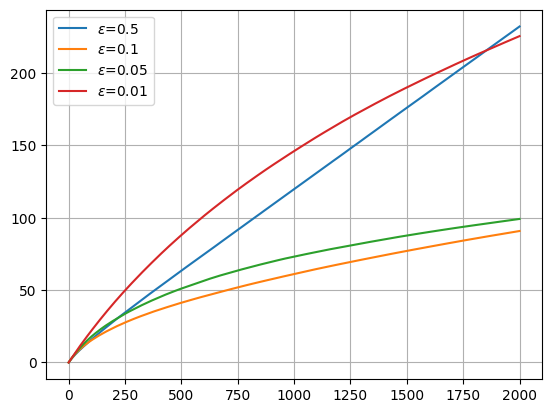

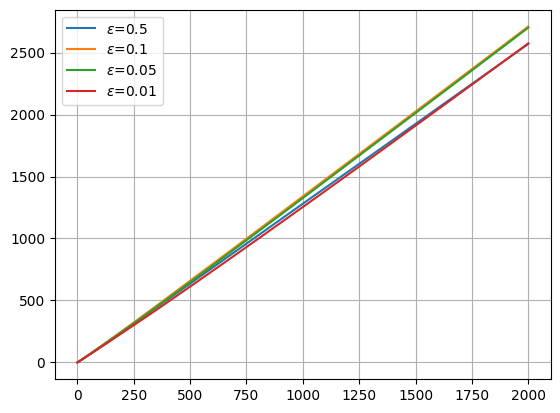

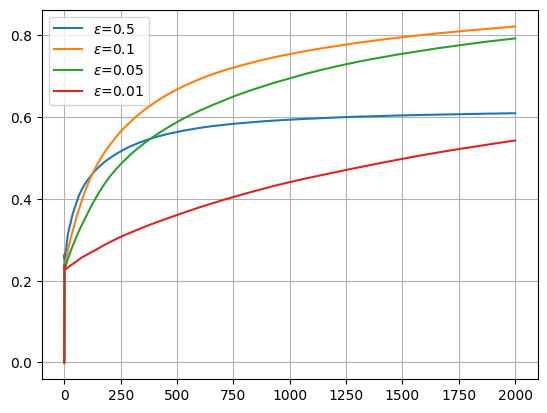

In [348]:
a=trial(b,est,eps)
a.add_runs(k,n)
a.plot('reg')
a.plot('rew')
a.plot('rel')

1b

In [349]:
means=[1,1.2,1.1,1.4]
std=[0.2,0.4,0.6,0.8]
inits=[2,2,2,2]
b=bandit(4,means,std)
eps=[0.5,0.1,0.05,0.01]
est=epsilon_greedy_estimator
n=2000
k=1000

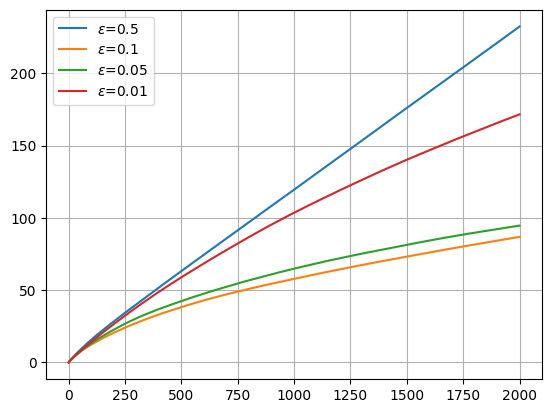

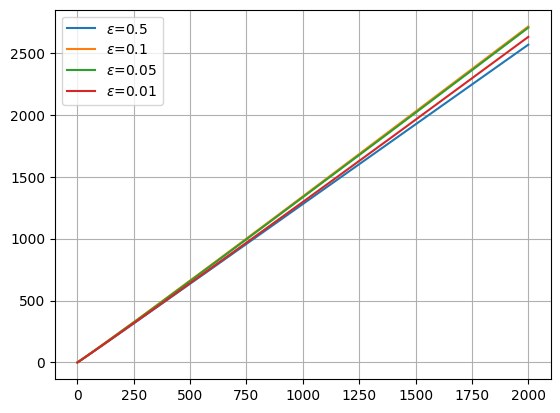

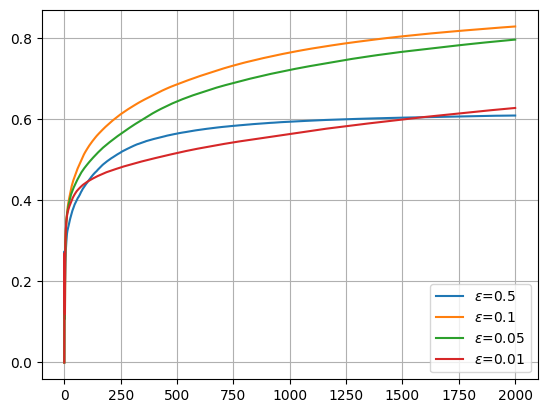

In [350]:
a=trial(b,est,eps,inits)
a.add_runs(k,n)
a.plot('reg')
a.plot('rew')
a.plot('rel')

1c: Optimistic initalizations force the algorithm to visit each state at least once before, to reset the initialzition. 

In [351]:
print(a.inits)

[2, 2, 2, 2]
